**Features based clustering con k-means**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from tqdm import tqdm

**Calcolo score (definito come numero di incidenti data la settimana e la città)** 

In [14]:
df = pd.read_csv("data/time_Series_Data.csv")
df['date'] = pd.to_datetime(df['date'])
df['year_month_week'] = df['date'].dt.to_period('W').dt.strftime('%Y-%m-%W')

weekly_data = df.groupby(['year_month_week', 'city']).size().reset_index(name='incident_count')
weekly_data.dropna(inplace=True)

**Vengono prese in considerazione solo le città che presentano un numero di settimane con incidenti che supera il 15% del totale delle settimane nell’arco dei 4 anni.**

In [15]:
selected_city = weekly_data.groupby(['city']).count()
selected_city = selected_city[selected_city.year_month_week >= 32].reset_index()['city']
df = weekly_data[weekly_data.city.isin(selected_city)]

df = df.pivot(index="city", columns="year_month_week", values="incident_count")
df.fillna(0, inplace=True)
df.head()

year_month_week,2014-01-00,2014-01-01,2014-01-02,2014-01-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-03-08,2014-03-09,...,2017-10-43,2017-11-44,2017-11-45,2017-11-46,2017-11-47,2017-12-48,2017-12-49,2017-12-50,2017-12-51,2017-12-52
city,,,,,,,,,,,,,,,,,,,,,
Aberdeen,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Abilene,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aiken,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,1.0
Akron,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,4.0,1.0,1.0,4.0,2.0,2.0,3.0
Albany,1.0,0.0,5.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,...,4.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


**Calcolo features**

In [16]:
def calculate_stats(row):

    return pd.Series({
        'avg': row.mean(),
        'std': row.std(),
        'var': row.var(),
        'med': row.median(),
        'max': row.max(),
        'min': row.min(),
        '10p': row.quantile(0.1),
        '25p': row.quantile(0.25),
        '50p': row.quantile(0.5),
        '75p': row.quantile(0.75),
        '90p': row.quantile(0.9),
        'iqr': row.quantile(0.75)-row.quantile(0.25),
        'cov': row.mean()/row.std() if row.std() != 0 else np.nan,
        'skw': stats.skew(row),
        'kur': stats.kurtosis(row)
    })

# Applica la funzione su DataFrame
stats_df = df.apply(calculate_stats, axis=1)
stats_df


,avg,std,var,med,max,min,10p,25p,50p,75p,90p,iqr,cov,skw,kur
city,,,,,,,,,,,,,,,
Aberdeen,0.272727,0.543557,0.295455,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.501745,2.054952,4.178303
Abilene,0.478469,0.814983,0.664198,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.587090,1.858936,3.369347
Aiken,0.727273,0.934012,0.872378,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.778655,1.346757,1.438676
Akron,1.545455,1.278179,1.633741,1.0,7.0,0.0,0.0,1.0,1.0,2.0,3.0,1.0,1.209107,0.853934,1.064249
Albany,1.732057,1.412505,1.995169,1.0,8.0,0.0,0.0,1.0,1.0,3.0,3.2,2.0,1.226231,0.974053,1.539486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yakima,0.430622,0.829863,0.688673,0.0,5.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.518907,2.346428,6.331588
Yonkers,0.263158,0.539437,0.290992,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.487838,2.130891,4.518544
York,1.282297,1.201651,1.443964,1.0,6.0,0.0,0.0,0.0,1.0,2.0,3.0,2.0,1.067113,1.044147,0.974772


**Troviamo miglior valore di k su k-means**

In [17]:
def k_means_feature_based(x_cluster, max_k):
    
    scaler = MinMaxScaler()
    X_minmax = scaler.fit_transform(x_cluster)
    
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over {0} possible K values".format(max_k)):
        kmeans_iter = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=100)
        kmeans_iter.fit(X_minmax)
        
        davies_list.append(davies_bouldin_score(X_minmax, kmeans_iter.labels_))
        sil_list.append(silhouette_score(X_minmax, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

def plot_indicators(sse_list, sil_list, davies_list):
    max_k = len(sse_list)+1
    _, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Indicatori clustering", fontsize=22)

Iterating over 30 possible K values: 100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


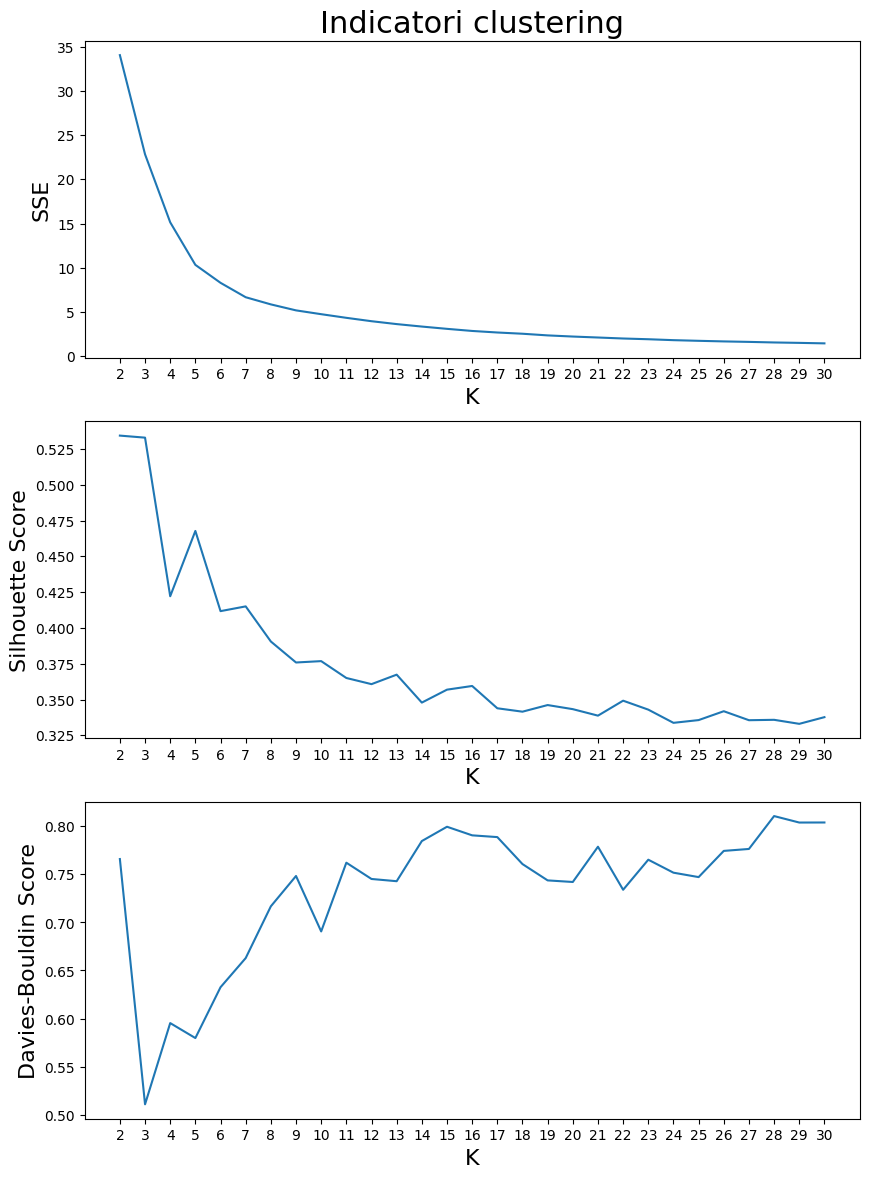

In [18]:
sse, sil, davies_bouldin = k_means_feature_based(stats_df, 30)
plot_indicators(sse, sil, davies_bouldin)

Con l'elbow method non è immediato determinare il valore di k, ma con k=3 si ha il minor valore per Davies-Bouldin Sore e il seconod valore più grande per Silhouette Score

**Interpretazione risultati con K=3**

In [19]:
k = 3 # best k value
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(stats_df)
kmeans = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=100)
kmeans.fit(stats_df)
print("SSE:", sse[k-2], " - SILHOUETTE:", sil[k-2], " - DAVIES-BOULDIN:", davies_bouldin[k-2])

SSE: 22.83100173727813  - SILHOUETTE: 0.5328760229287874  - DAVIES-BOULDIN: 0.5107916298497263


**Numero di serie temporali per cluster**

In [20]:
# Ottieni le etichette dei cluster per ogni punto dati
labels = kmeans.labels_

# Calcola il conteggio per ogni cluster
unique, counts = np.unique(labels, return_counts=True)

# Crea un dizionario con i cluster come chiavi e i conteggi come valori
cluster_counts = dict(zip(unique, counts))

# Stampa il conteggio per ogni cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} serie temporali")

Cluster 0: 171 serie temporali
Cluster 1: 399 serie temporali
Cluster 2: 1 serie temporali


**Plot serie temporali in base al cluster**

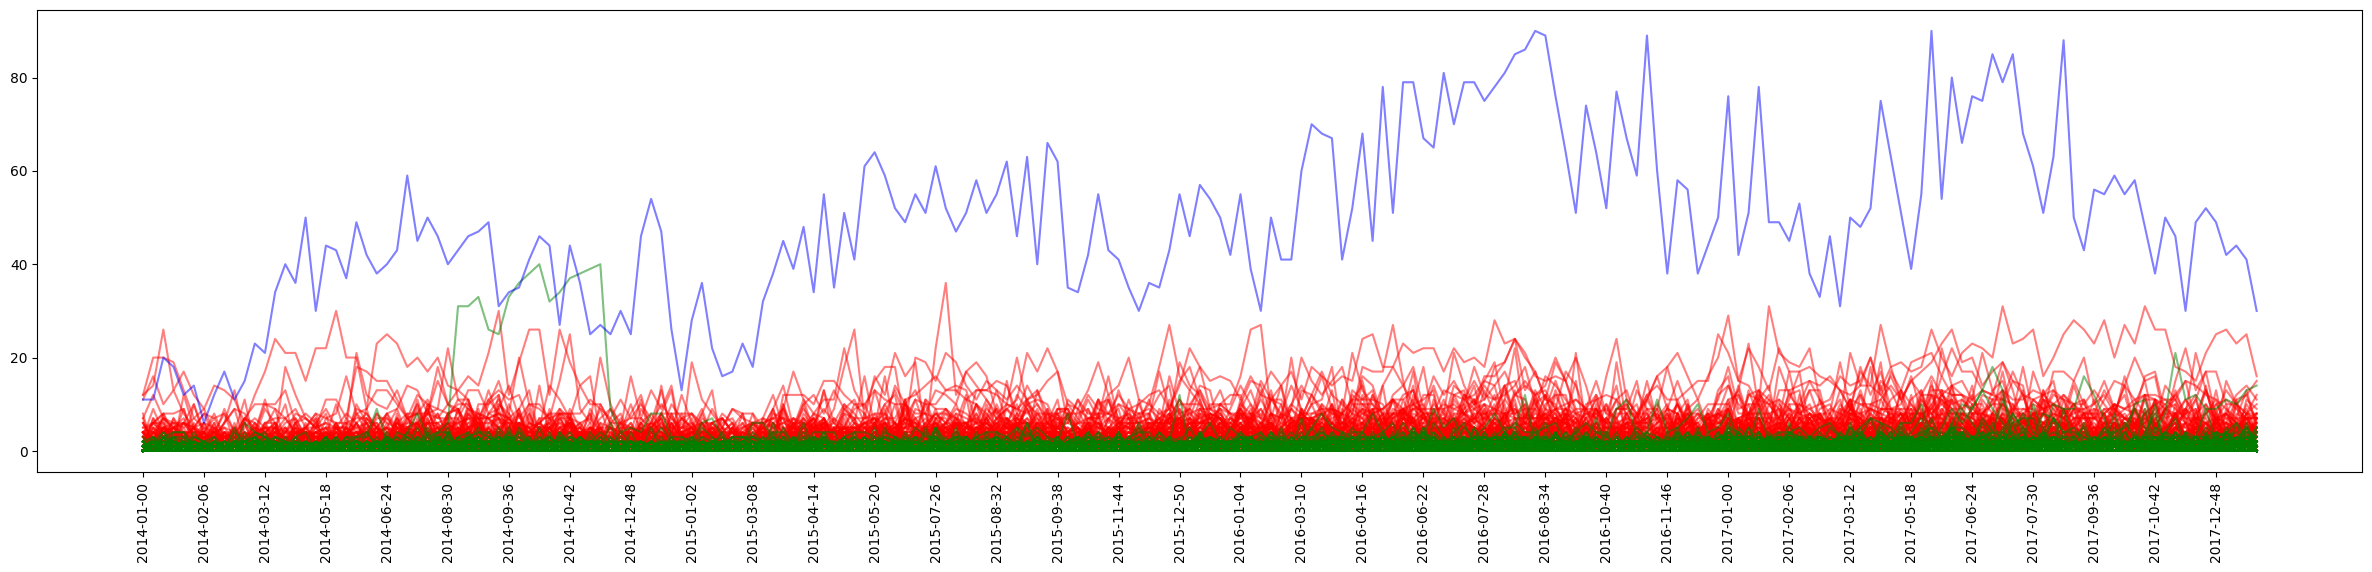

In [26]:
labels = kmeans.labels_

# Crea una lista di colori unici per ogni cluster
colors = ['red', 'green', 'blue']

plt.figure(figsize=(30,6))
for i, color in enumerate(colors):
    idx = np.where(labels == i)
    
    plt.plot(df.iloc[idx].T, color=color, alpha=0.5)

# Seleziona un sottoinsieme di etichette da mostrare
xticks = plt.xticks()[0]
num_xticks = len(xticks)
step = num_xticks // 30  # Mostra solo 10 etichette
plt.xticks(xticks[::step], rotation='vertical')  # Mostra ogni 'step' etichetta

# Mostra il grafico
plt.show()


**Distribuzione del numero di persone coinvolte in incidenti per cluster**

In [22]:
cluster_0 = df[labels == 0]
cluster_1 = df[labels == 1]
cluster_2 = df[labels == 2]

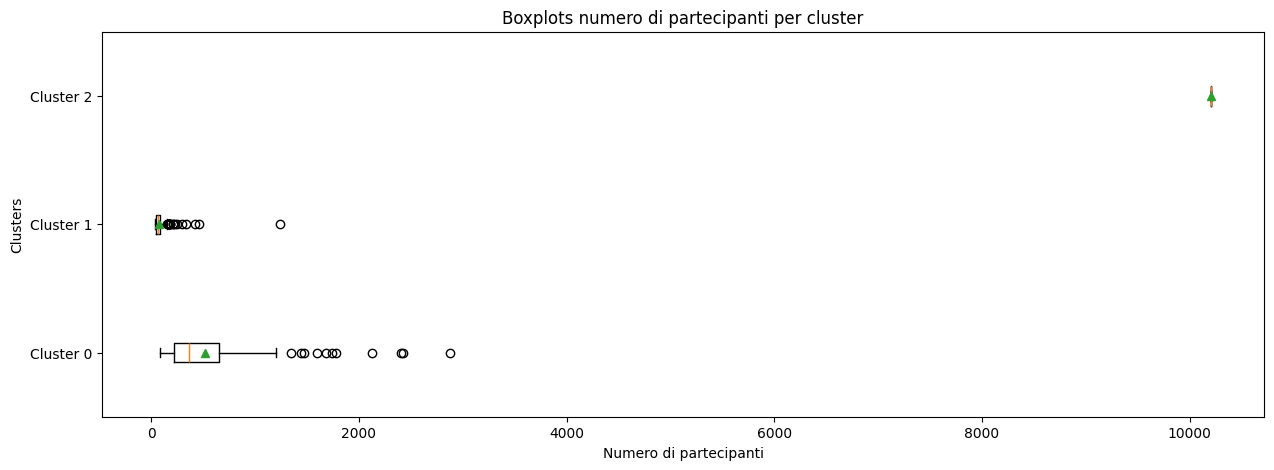

In [23]:
plt.figure(figsize=(15, 5))

positions = [1, 2, 3]

plt.boxplot(cluster_0.sum(axis=1), vert=False, showmeans=True, positions=[positions[0]], labels=["Cluster 0"])
plt.boxplot(cluster_1.sum(axis=1), vert=False, showmeans=True, positions=[positions[1]], labels=["Cluster 1"])
plt.boxplot(cluster_2.sum(axis=1), vert=False, showmeans=True, positions=[positions[2]], labels=["Cluster 2"])

plt.xlabel("Numero di partecipanti")
plt.ylabel("Clusters")
plt.title("Boxplots numero di partecipanti per cluster")
plt.show()

**Distribuzione del numero di settimane in cui è avvenuto almeno un incidente per cluster**

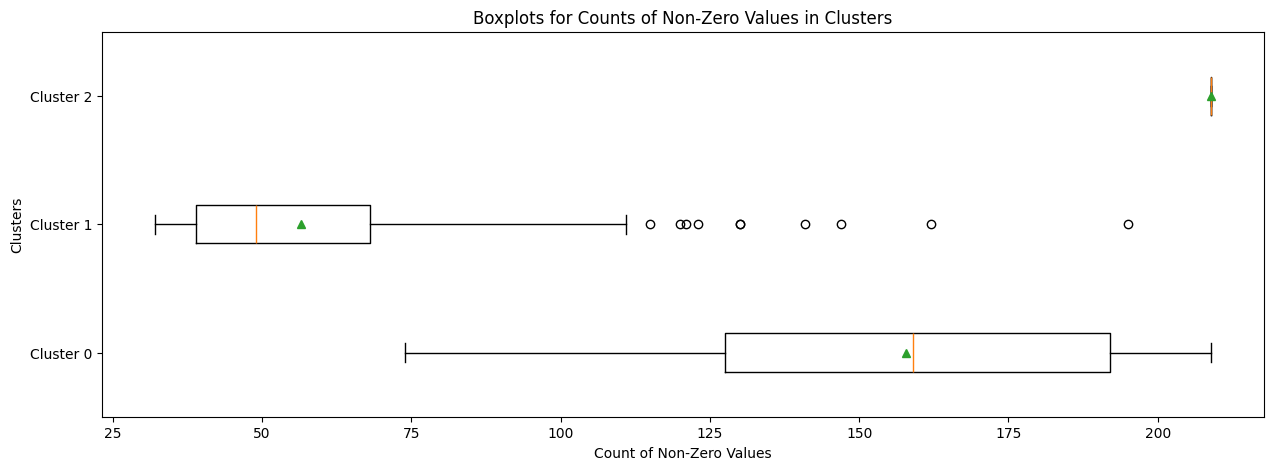

In [24]:
plt.figure(figsize=(15, 5))

counts_cluster_0 = cluster_0.apply(lambda row: (row != 0).sum(), axis=1)
counts_cluster_1 = cluster_1.apply(lambda row: (row != 0).sum(), axis=1)
counts_cluster_2 = cluster_2.apply(lambda row: (row != 0).sum(), axis=1)

positions = [1, 2, 3]
plt.boxplot([counts_cluster_0, counts_cluster_1, counts_cluster_2], vert=False, showmeans=True, positions=positions, labels=["Cluster 0", "Cluster 1", "Cluster 2"])

plt.xlabel("Count of Non-Zero Values")
plt.ylabel("Clusters")
plt.title("Boxplots for Counts of Non-Zero Values in Clusters")
plt.show()


Come è possibile osservare, le città sono suddivise in base al numero di incidenti che avvengono alla settimana